# Parameter variation
Goal is to see how much binary parameters can vary but still result in stacked transits.

In [1]:
import copy
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import astropy.units as u
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Kepler 16
cb = funcs.CBSystem(m1 = 0.6897,f1 = 1.,m2 = 0.20255,f2 = 0.01555,
                    ab = 0.22431,r1 = 0.6489 * u.Rsun.to('au'),r2 = 0.22623 * u.Rsun.to('au'),
                    eb = 0.15944,ib = np.deg2rad(90.3401),wb = np.deg2rad(263.464),
                    fb = np.deg2rad(186.53239),
                    mp = .03e-3,ap = 0.7048,rp = 0.7538 * u.Rjupiter.to('au'),ep = 0.0069,
                    ip = np.deg2rad(90.0322),wp = np.deg2rad(318.0),fp = np.deg2rad(148.92),
                    t0 = 2455212.12316)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)

41.0790034492


In [3]:
# make our reference light curve, with no eclipses/occultations
dt = 0.02
t = np.arange(2454953,2456424,dt)

f_pl = funcs.pd_cb(cb, times=t)
tmp = cb.rp
cb.rp = 0.0
f_nopl = funcs.pd_cb(cb, times=t)
cb.rp = tmp
f_ref = f_pl / f_nopl

<IPython.core.display.Javascript object>


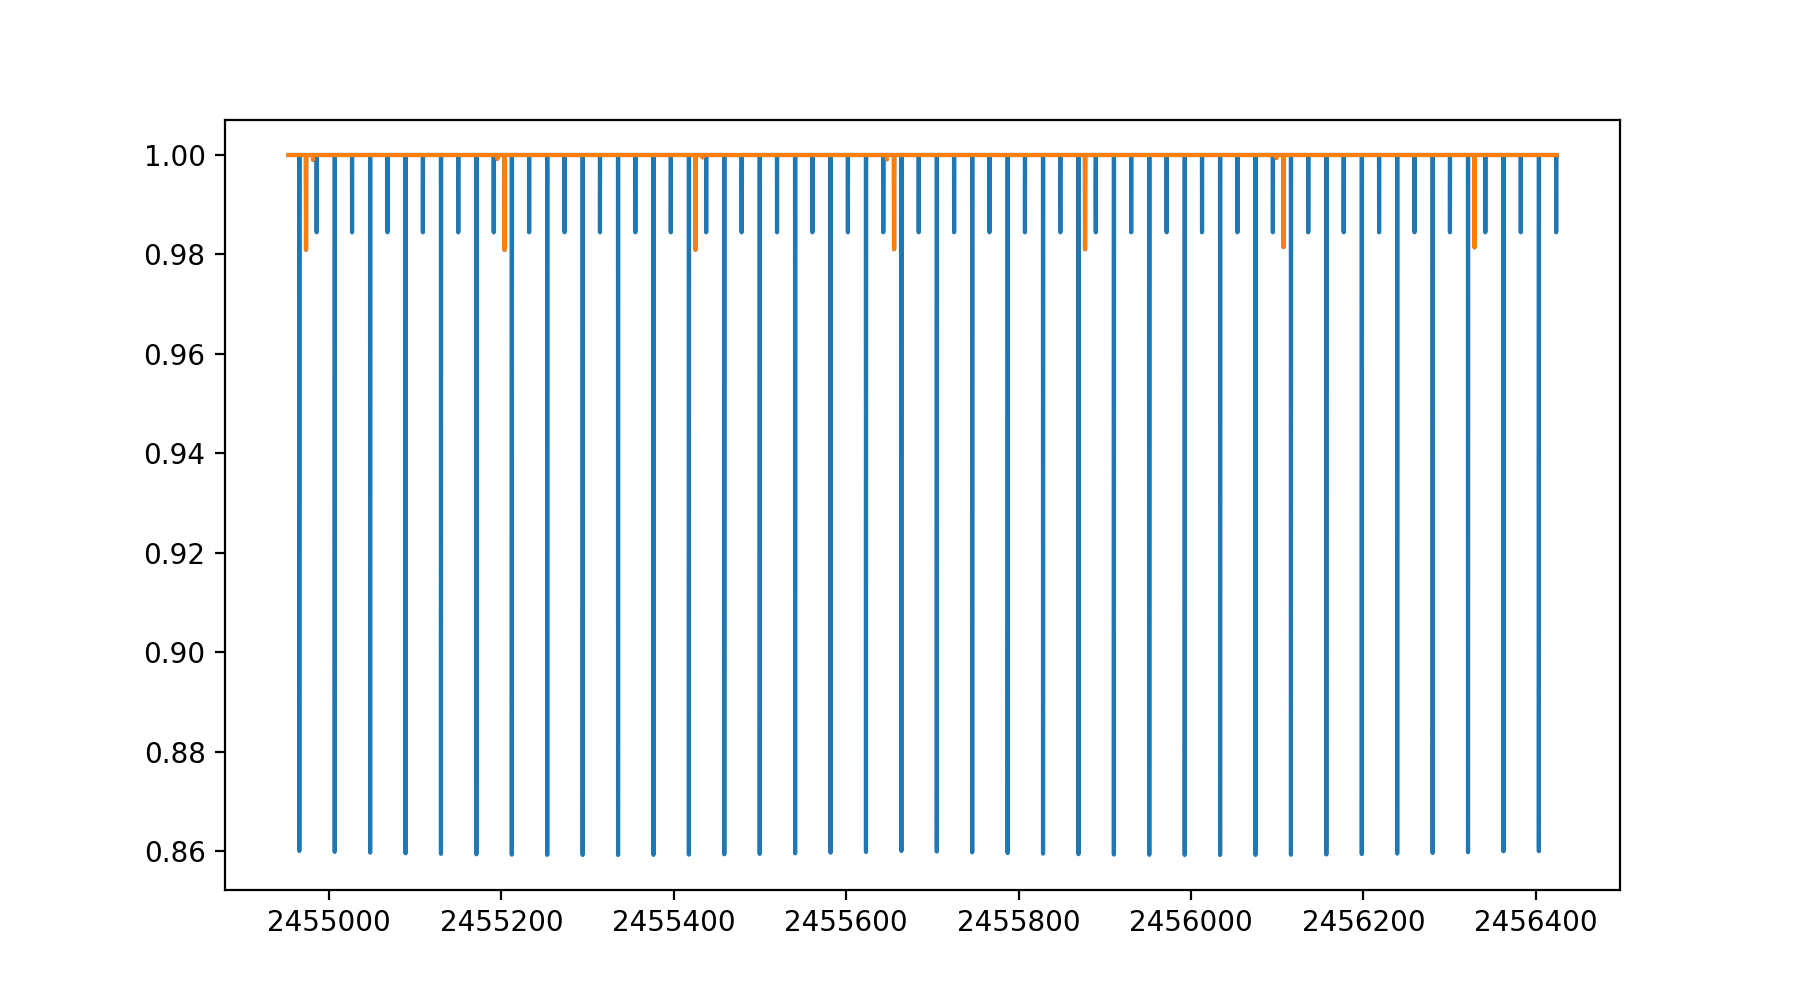

In [4]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(t,f_pl)
ax.plot(t,f_ref)

In [58]:
%timeit funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
%timeit funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))

72.6 ms ± 405 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.2 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


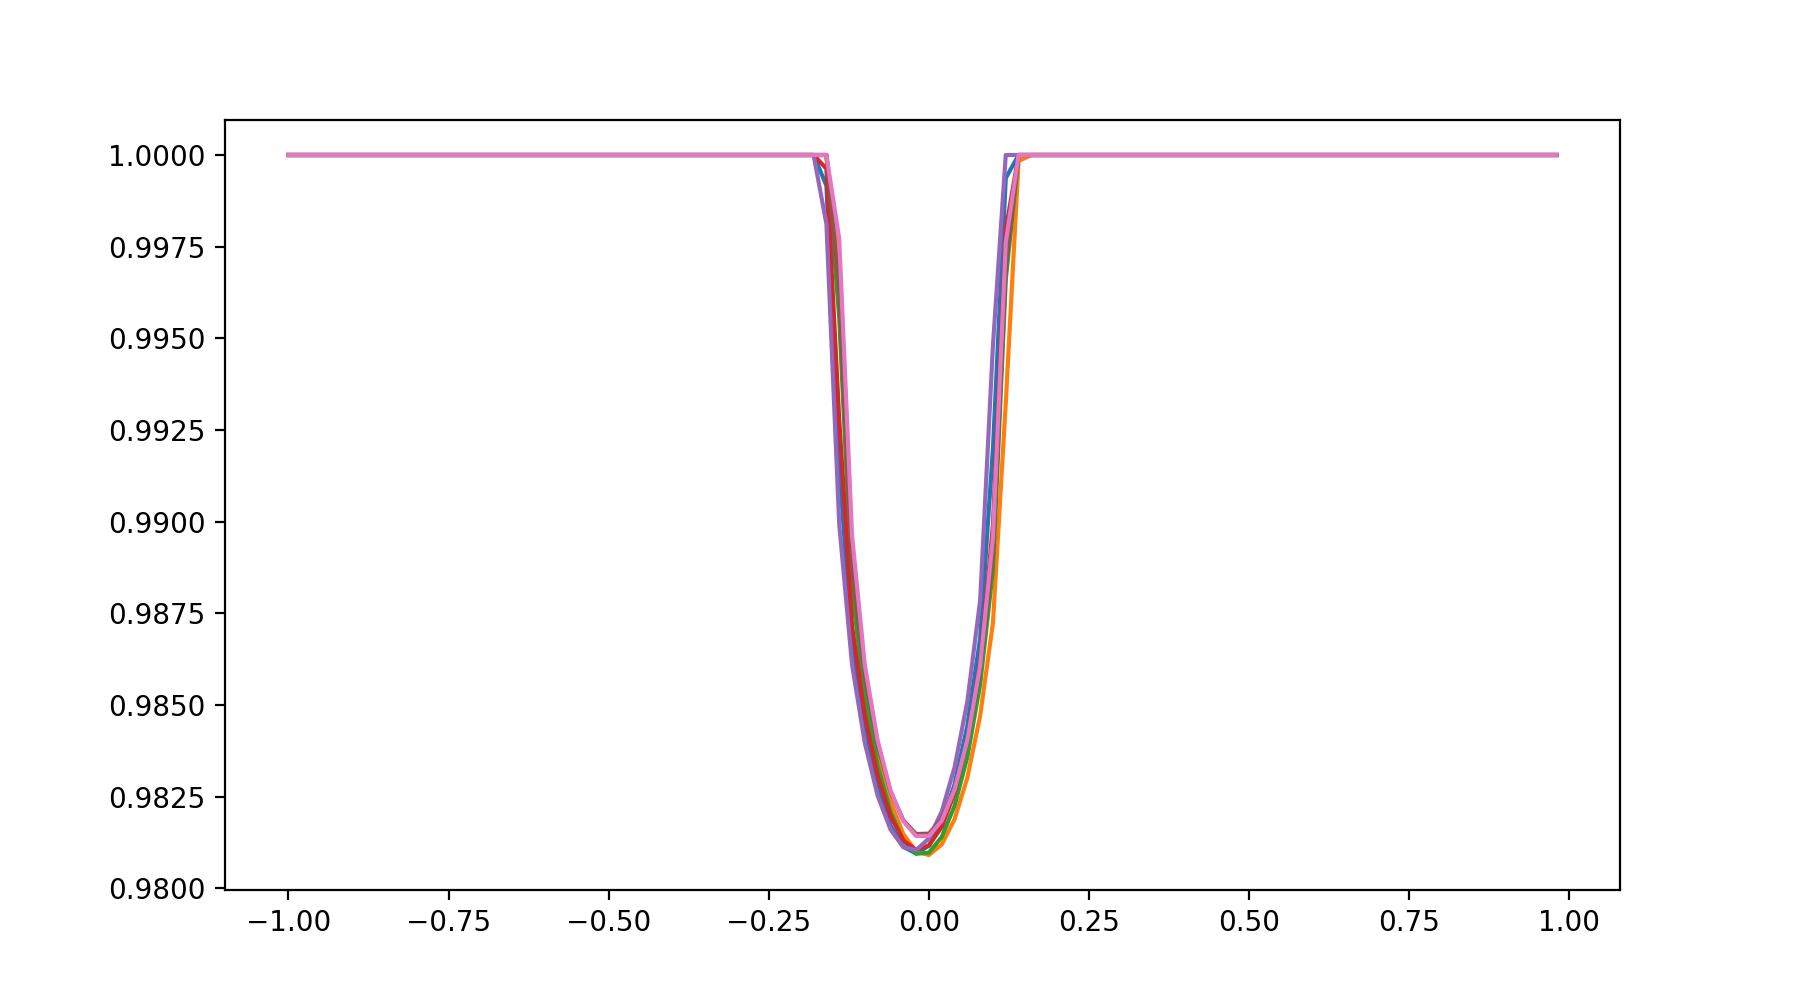

0.0228007586071


In [59]:
# and make the reference stacked light curve set
window = 1.0
tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
    
ok = tts[:,0] == 20
ref_tts = tts[ok]
ref_stack = ()
for tt in tts[ok,1]:
    in_win = (-window < (t-tt)) & ((t-tt) < window)
    ref_stack += (f_ref[in_win],)
    
fig,ax = plt.subplots(figsize=(9,5))
for f in ref_stack:
    ax.plot(np.arange(-window,window,dt),f)
    
null_chi2 = np.sum([(r-1)**2 for r in ref_stack])
print(null_chi2)

In [8]:
# log likelihood function, based on timing
def lnlike(par, *args):
    cb, t, f = args
    cb.m1, cb.m2, cb.eb, cb.wb, cb.ap, cb.fp = par
    # force period to be fixed
    cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.)

    try:
        tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
    except:
        return -np.inf

    ok = tts[:,0] == 20
    if np.sum(ok) != len(ref_tts):
        return -np.inf

    # metric based on 1sigma being some fraction of a day/transit
    dts = tts[ok,1] - ref_tts[:,1]
    diff = np.sum( (np.abs(dts)/0.1)**2 )
#     print(dts,-0.5*diff)

    return -0.5 * diff

In [18]:
# run emcee to see where we go
nwalkers = 32
par0 = [cb.m1, cb.m2, cb.eb, cb.wb, cb.ap, cb.fp]
labels = ['m1','m2','eb','wb','ap','fp']
npar = len(par0)
par0 = [ par0 + par0*np.random.normal(scale=0.001,size=npar) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, npar, lnlike, args=(copy.deepcopy(cb), t, f), threads=8 )
pos,lnprob,rstate = sampler.run_mcmc(par0, 5000)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


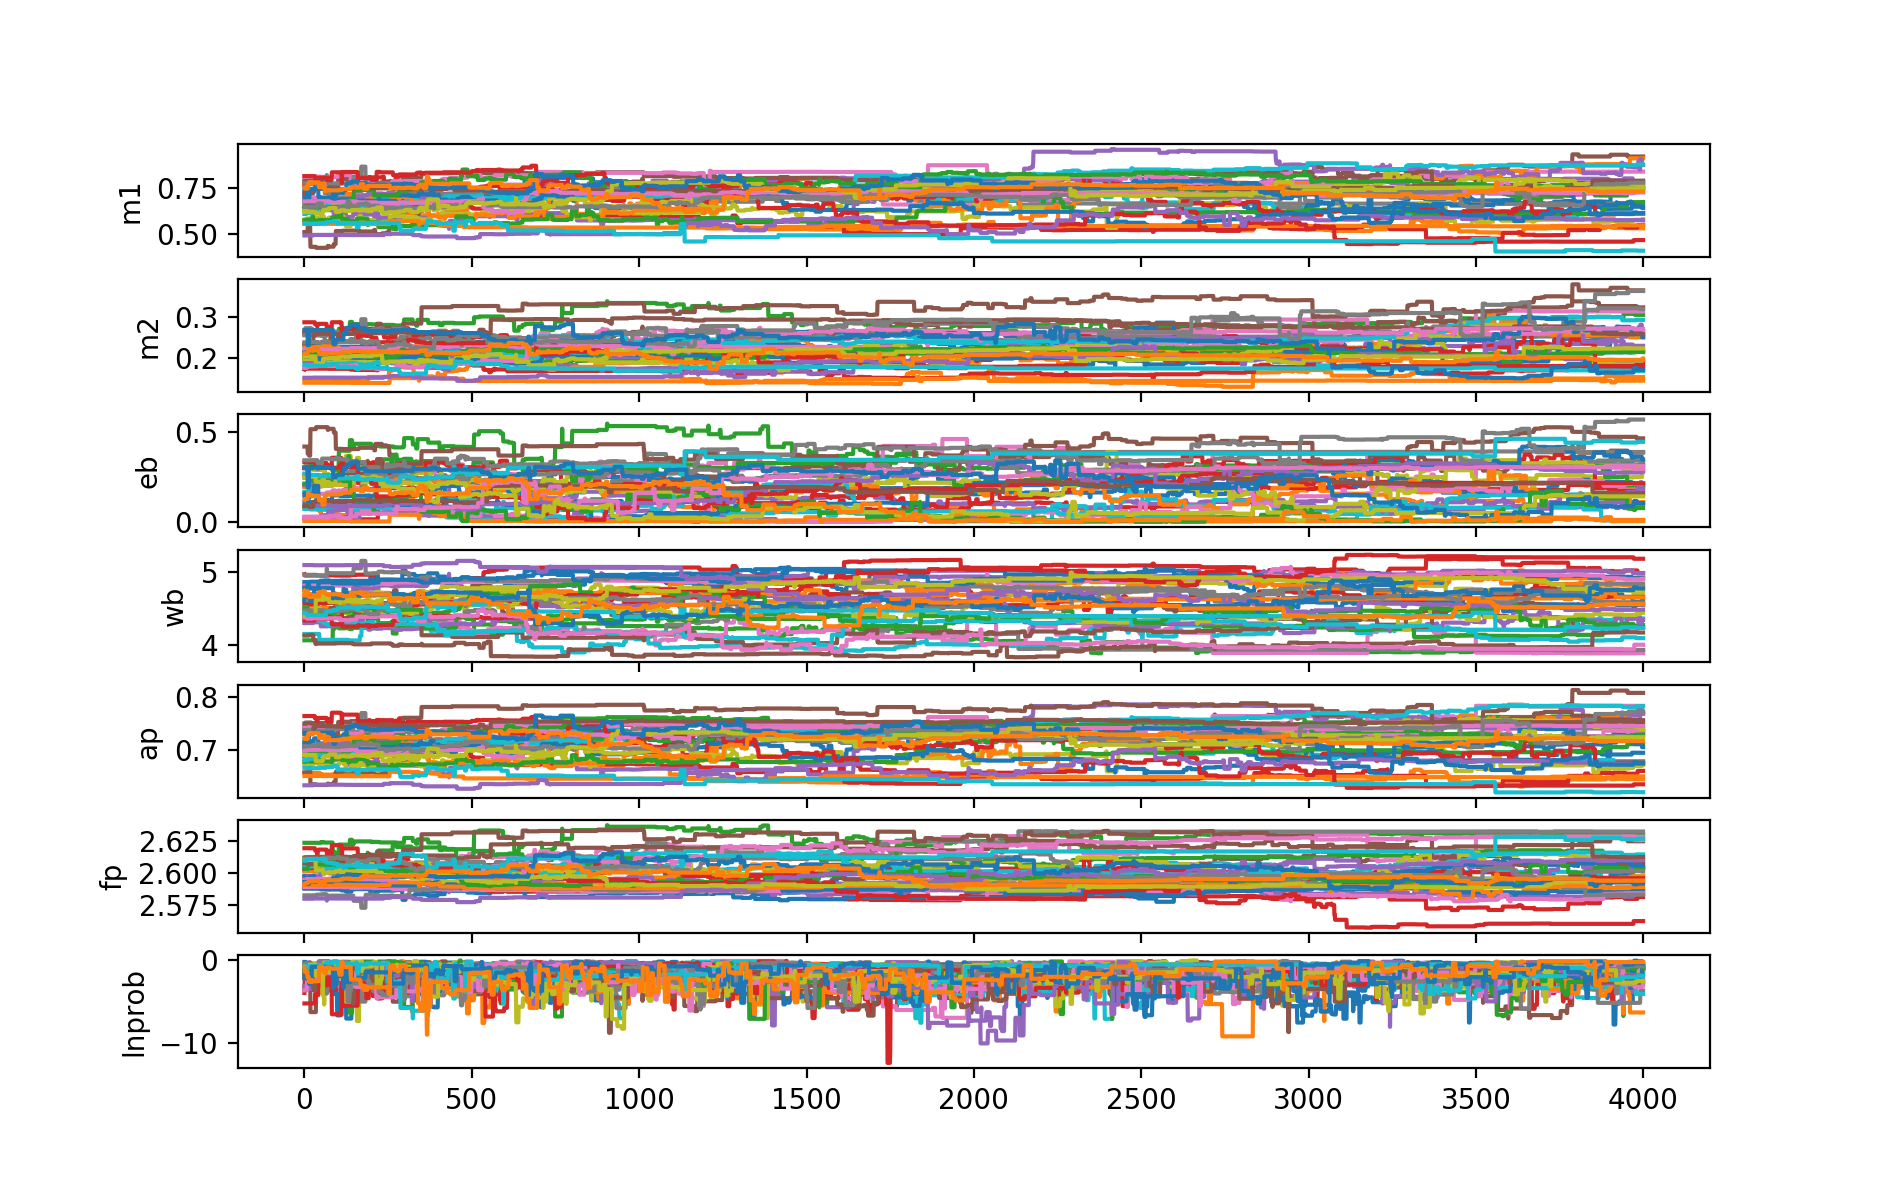

In [22]:
burn_in = 1000
fig,ax = plt.subplots(npar+1,figsize=(9.5,npar),sharex=True)
for j in range(nwalkers):
    ax[npar].plot(sampler.lnprobability[j,burn_in:])
    ax[npar].set_ylabel('lnprob')
    for i in range(npar):
        ax[i].plot(sampler.chain[j,burn_in:,i])
        ax[i].set_ylabel(labels[i])

<IPython.core.display.Javascript object>


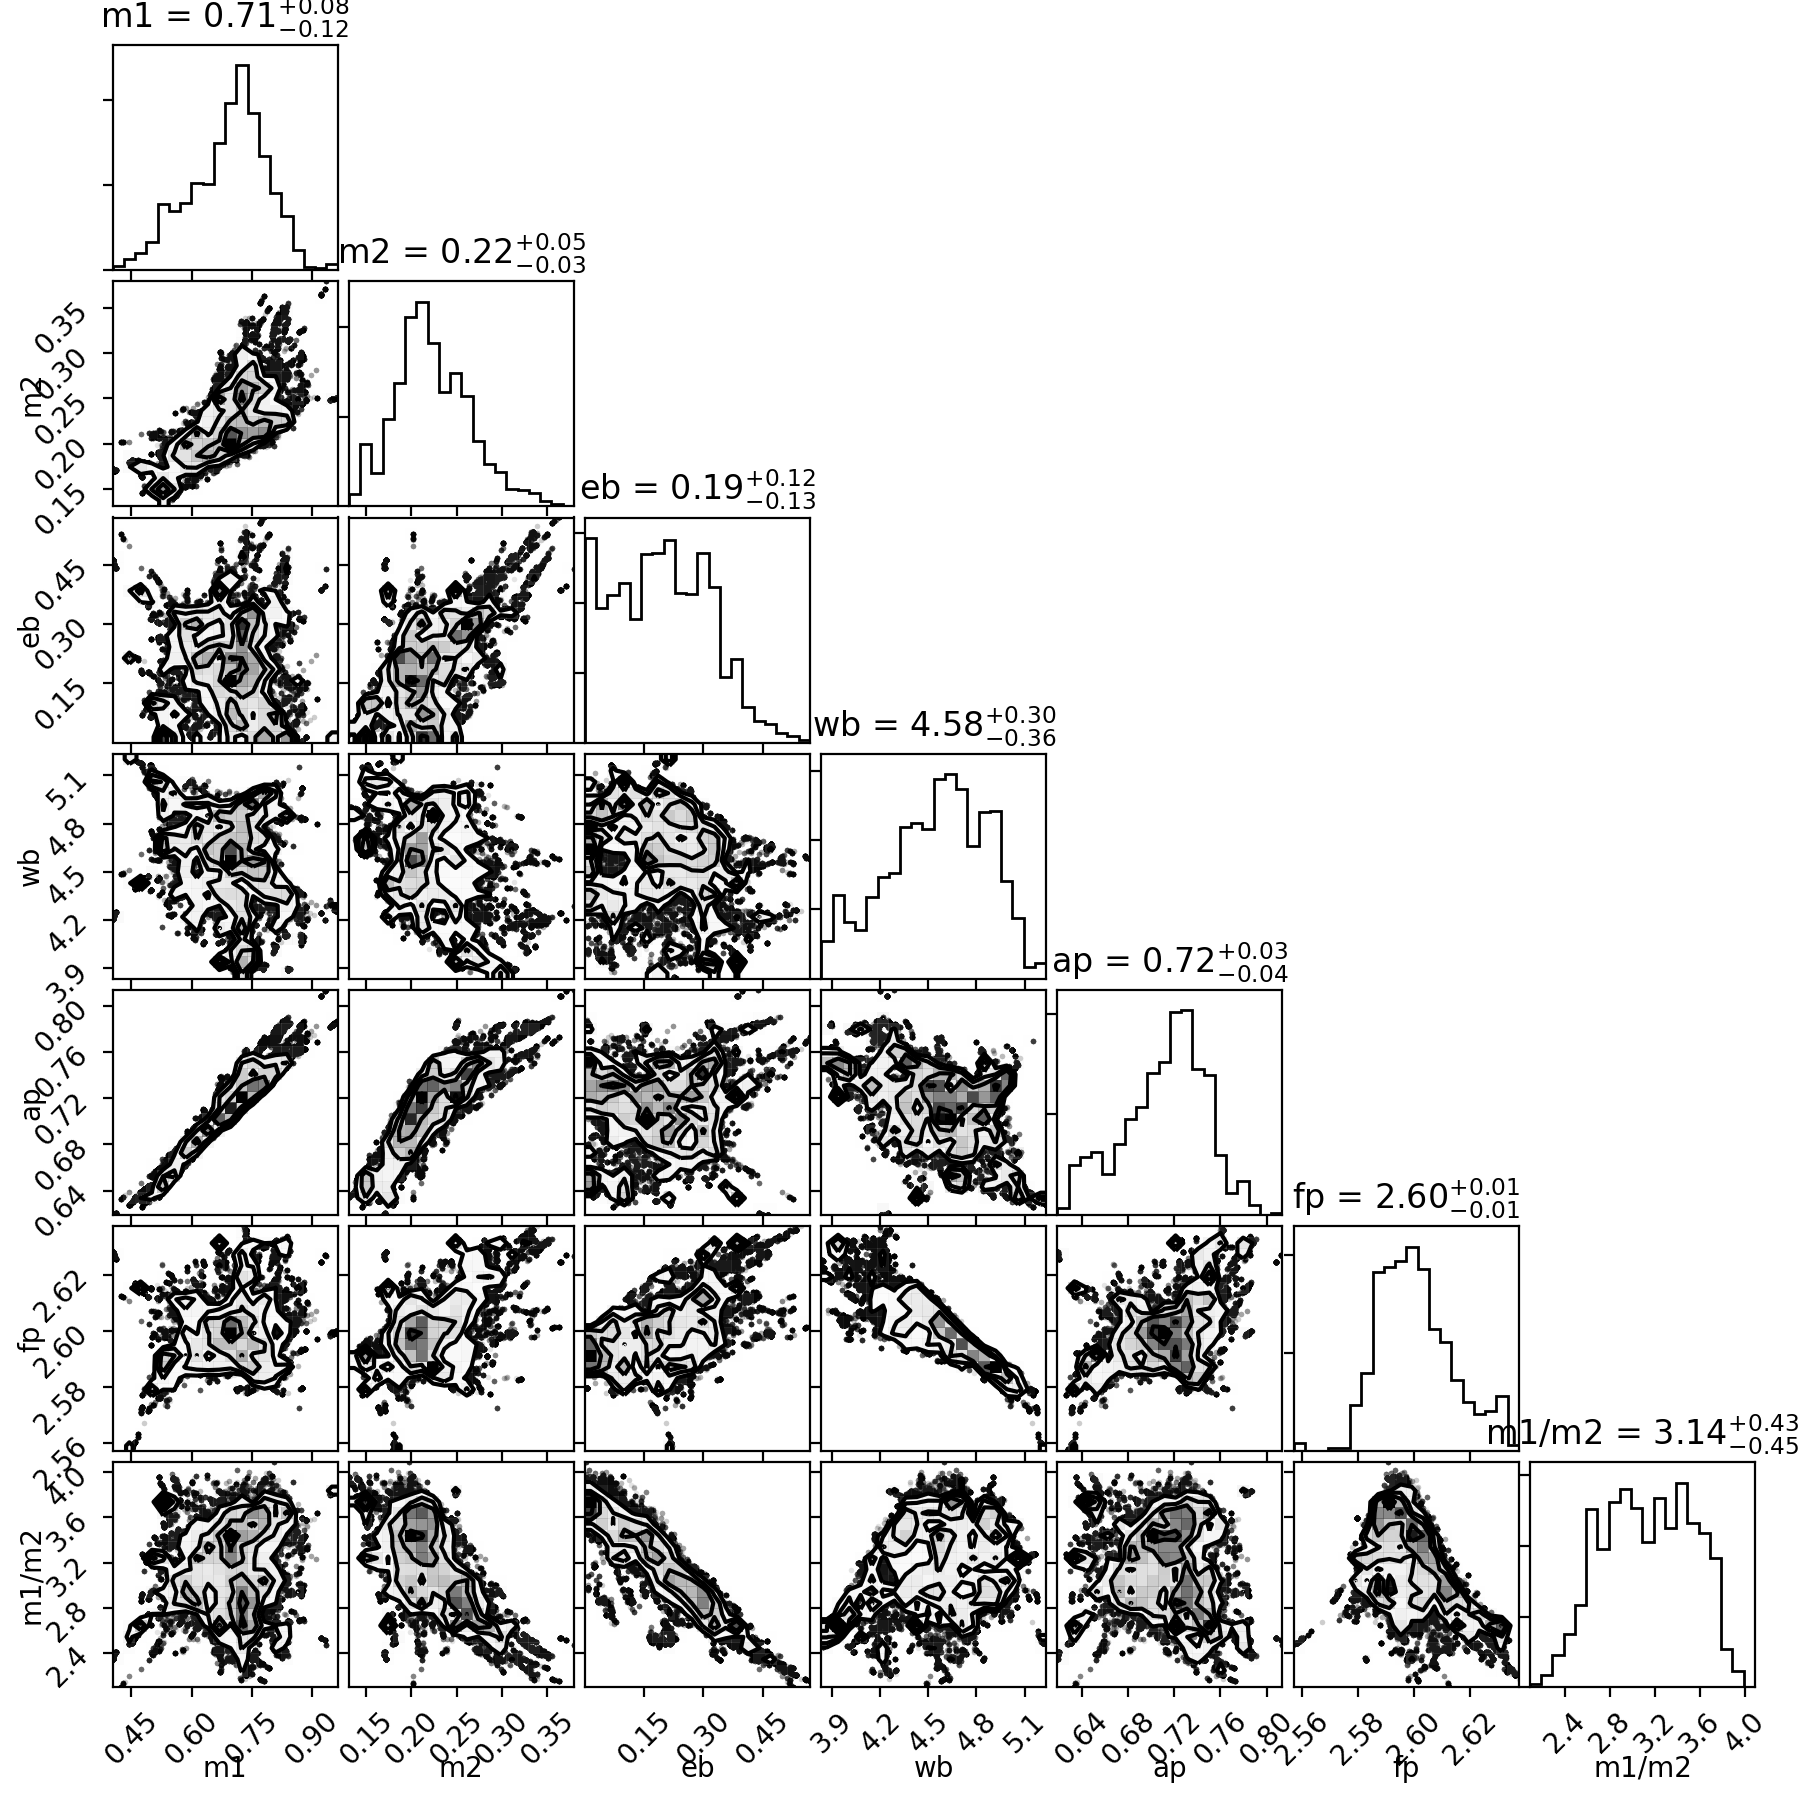

In [20]:
chains = sampler.flatchain[burn_in:]
chains = np.vstack((chains.T,chains[:,0]/chains[:,1])).T
labels += ['m1/m2']
fig,ax = plt.subplots(npar+1,npar+1,figsize=(9,9))
fig = corner.corner(chains,labels=labels,fig=fig,show_titles=True)

<IPython.core.display.Javascript object>


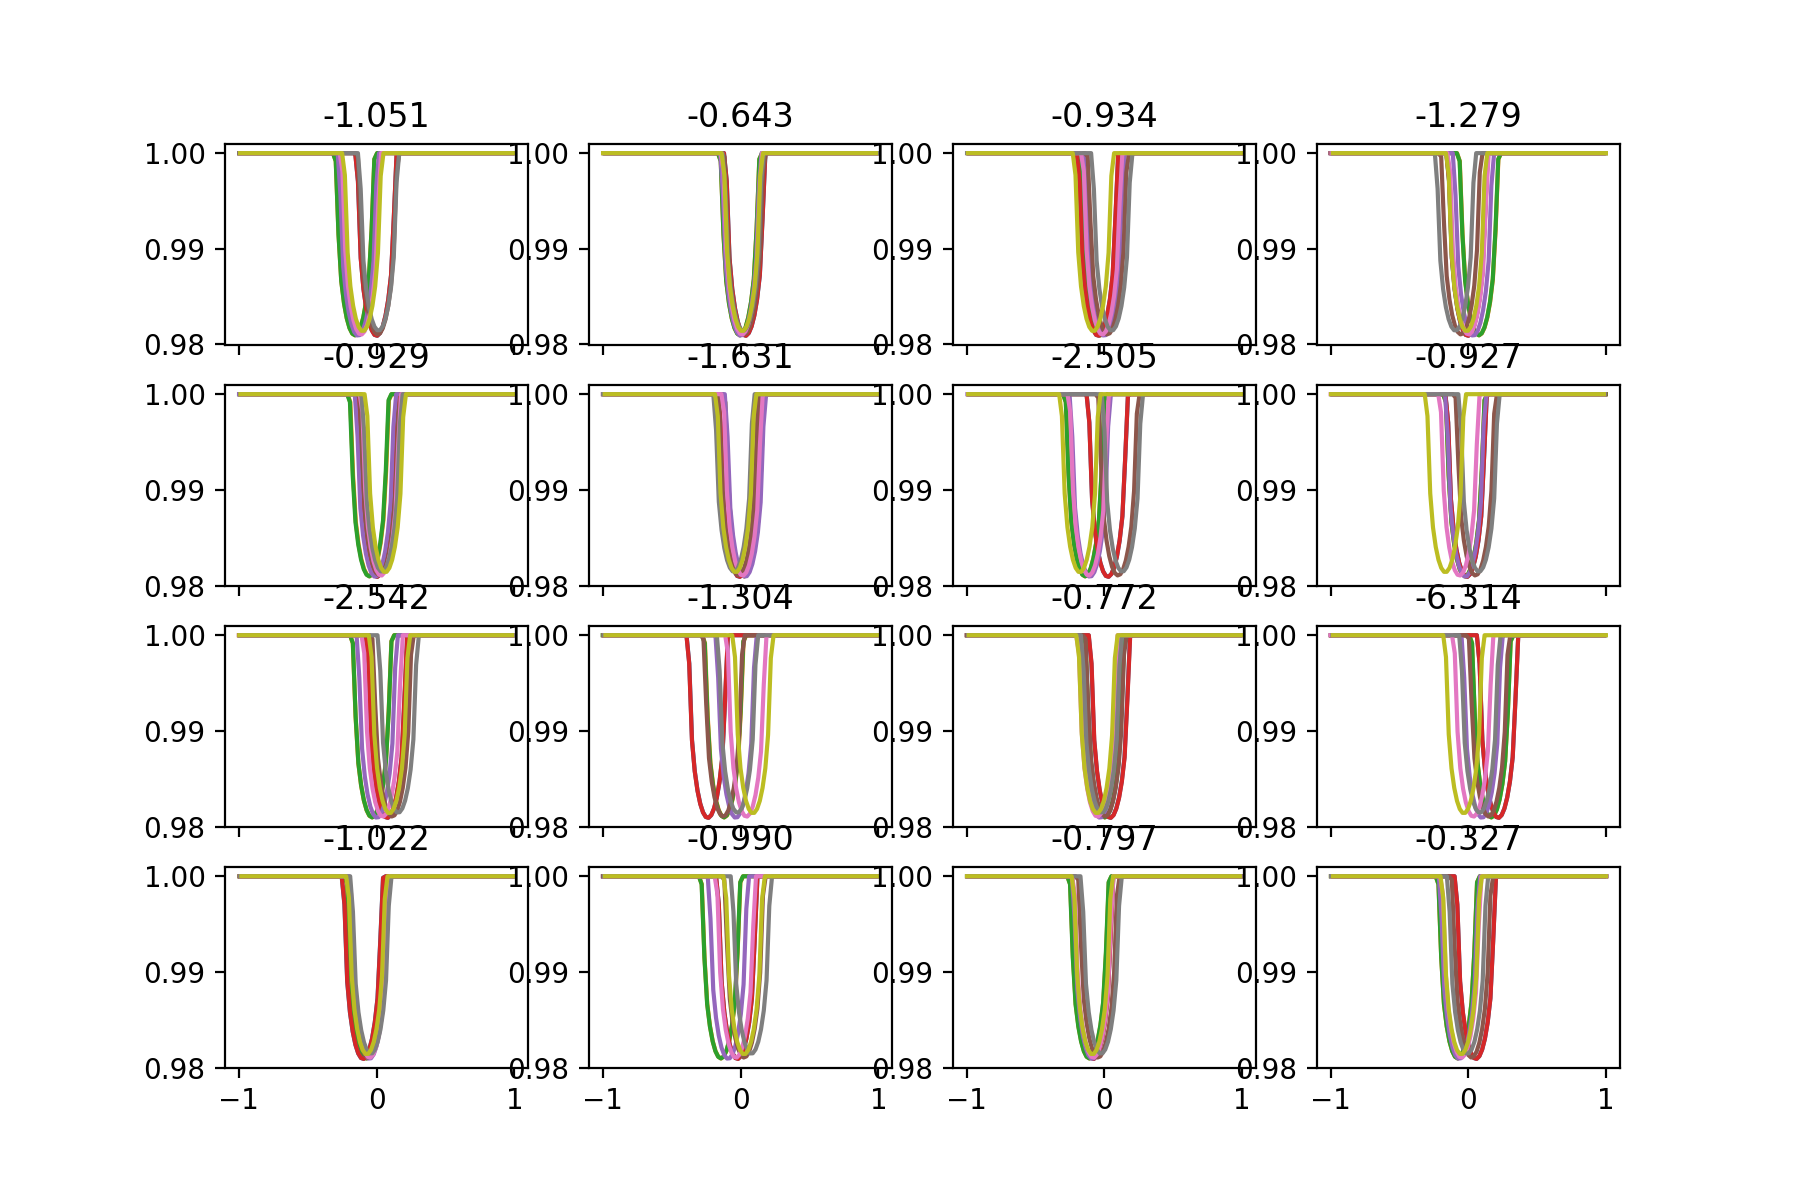

In [23]:
cb1 = copy.deepcopy(cb)

fig,ax = plt.subplots(4,4,figsize=(9,6),sharex=True)

for i in range(4):
    for j in range(4):
        
        cb1.m1, cb1.m2, cb1.eb, cb1.wb, cb1.ap, cb1.fp = sampler.chain[4*i+j,-1,:]
        cb1.ab = ab0 * ( (cb1.m1+cb1.m2)/mb0 )**(1/3.)
        tts = funcs.reb_cb(cb1,tmin=np.min(t),tmax=np.max(t))

        ok = tts[:,0] == 20
        for tt in tts[ok,1]:
            in_win = (-window < (t-tt)) & ((t-tt) < window)
            ax[i,j].plot((t-tt)[in_win],f_ref[in_win])
            
        ax[i,j].set_title('{:5.3f}'.format(lnlike(sampler.chain[4*i+j,-1,:],*(cb1, t, f))))